In [1]:
import os 
import numpy as np
import torch 
import matplotlib.pyplot as plt

In [2]:
reverb_log_dir = '../Logs/circular_array_7mic/reverb/'
noisy_log_dir = '../Logs/circular_array_7mic/noisy/point_source'
noisy_reverb_ps_log_dir = '../Logs/circular_array_7mic/noisy_reverb/point_source'
noisy_reverb_diffuse_log_dir = '../Logs/circular_array_7mic/noisy_reverb/diffuse'

In [3]:
Loss = ["MIMO_RI", "MIMO_RI_MAG", "MIMO_RI_MAG_PD", "MIMO_RI_PD", "MIMO_RI_PD_REF"]
num_mics_list = [7]
doa_measures = ["frm_Acc_epoch", "utt_Acc_epoch", 'mae_only_correct', 'mae_only_incorrect', 'mae_overall']
se_measures = ["STOI", "PESQ_NB", "SNR"]

In [4]:
search_doa_pattern_list = []
for loss in Loss:
    for measure in doa_measures:
        doa_info_pattern = f'{loss}_{measure}' #inside file pattern
        search_doa_pattern_list.append(doa_info_pattern)

search_doa_pattern_list.append("mix_7mic_frm_Acc_epoch")          

In [5]:
reverb_doa_measures = ["est_frm_Acc_epoch", "est_utt_Acc_epoch", 'est_mae_only_corr', 'est_mae_only_incorr', 'est_mae_overall']
reverb_search_doa_pattern_list = []
for loss in Loss:
    for measure in reverb_doa_measures:
        doa_info_pattern = f'{loss}_{measure}' #inside file pattern
        reverb_search_doa_pattern_list.append(doa_info_pattern)

reverb_search_doa_pattern_list.append("mix_frm_Acc_epoch") 

In [6]:
def get_test_config_details(line):
    snr,t60,app_str = None, None,""
    
    if "dataset_condition:" in line:
        line_split_info = line.split(',')
        if line_split_info[-1]=='':
            line_split_info.pop()
        dataset_condition = line_split_info[-1].split()[-1]
        if dataset_condition=="noisy":
            snr = line_split_info[-3].split()[-1]
            app_str = f'snr_{snr}'
        elif dataset_condition=="noisy_reverb":
            
            snr = line_split_info[-3].split()[-1]
            t60 = line_split_info[-4].split()[-1]
            app_str = f'snr_{snr}_t60_{t60}'
            
        elif dataset_condition=="reverb":
            t60 = line_split_info[-4].split()[-1]
            app_str = f't60_{t60}'

            
    return snr, t60, app_str

In [7]:
#search_pattern_file
def search_pattern_file(file_path, search_pattern_list):
    exp_dict = {}
    app_str = ""
    with open(file_path, 'r') as f:
        for line in f.readlines():
            line = line.strip()
            if app_str=="":
                snr, t60, app_str = get_test_config_details(line)
                
            for search_pattern in search_pattern_list: #search_doa_pattern_list:
                if search_pattern in line:
                    line_split_info = line.split()
                    #print(line_split_info, len(line_split_info))
                    if len(line_split_info)==5:
                        key_str = f'{search_pattern}_{app_str}'
                        exp_dict[key_str] = float(line_split_info[3])
                        #print(key_str, line.split()[3])
                
    return exp_dict
        


In [8]:
def get_all_exp_dict(log_dir: str, search_pattern: list):
    log_dir_files = os.listdir(log_dir)
    _exp_dict={}
    for _file in log_dir_files:
        file_path = os.path.join(log_dir, _file)
        exp_dict = search_pattern_file(file_path, search_pattern)
        _exp_dict.update(exp_dict)
    
    return _exp_dict

In [9]:
reverb_exp_dict = get_all_exp_dict(reverb_log_dir, reverb_search_doa_pattern_list)
noisy_exp_dict = get_all_exp_dict(noisy_log_dir, search_doa_pattern_list)
noisy_reverb_ps_exp_dict = get_all_exp_dict(noisy_reverb_ps_log_dir, search_doa_pattern_list)
noisy_reverb_diffuse_exp_dict = get_all_exp_dict(noisy_reverb_diffuse_log_dir, search_doa_pattern_list)

In [10]:
#plotting frm Acc
from itertools import product

noisy_snr_list = [-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]

noisy_reverb_snr_list = [-5.0, 0.0, 5.0, 10.0, 20.0 ]
noisy_reverb_t60_list = [0.2, 0.4, 0.6, 0.8, 1.0]
noisy_reverb_list = list(product(noisy_reverb_snr_list, noisy_reverb_t60_list))

reverb_t60_list = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [11]:
def build_app_str(dataset_condition, val):
    if dataset_condition=="noisy":
        app_str = f'snr_{val}'
    elif dataset_condition=="noisy_reverb":
        app_str = f'snr_{val[0]}_t60_{val[1]}'   
    elif dataset_condition=="reverb":
        app_str = f't60_{val}'
    return app_str

In [12]:
def _plot(measure, exp_dict, dataset_condition, tst_conditions, loss_list, dataset_simulation=""):
    plt.figure()
    for loss in loss_list:
        val_list = []
        for tst_val in tst_conditions:
            app_str = build_app_str(dataset_condition, tst_val)
            key_str = f'{loss}_{measure}_{app_str}'

            val_list.append(exp_dict[key_str])
        #print(loss, val_list)
        if dataset_condition != "noisy_reverb":
            plt.plot(tst_conditions, val_list) 
        else:
            plt.plot(val_list) 
    plt.legend(loss_list)
    plt.title(f'{dataset_condition}_{dataset_simulation}')
        
        


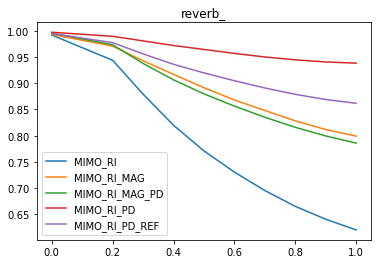

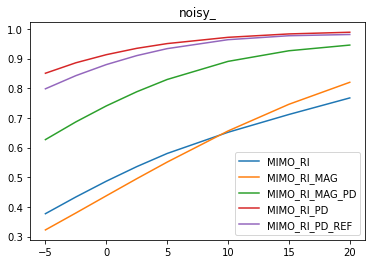

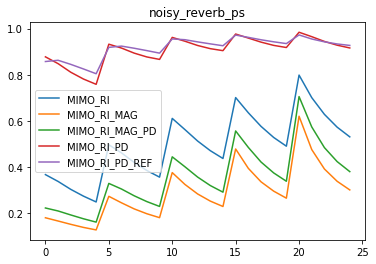

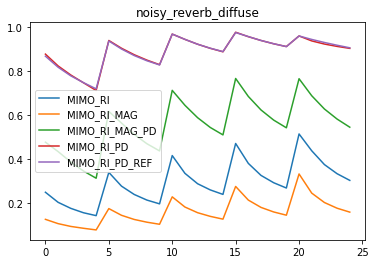

In [13]:
_plot("est_frm_Acc_epoch", reverb_exp_dict, "reverb", reverb_t60_list, Loss)
_plot("frm_Acc_epoch", noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_plot("frm_Acc_epoch", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_plot("frm_Acc_epoch", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")

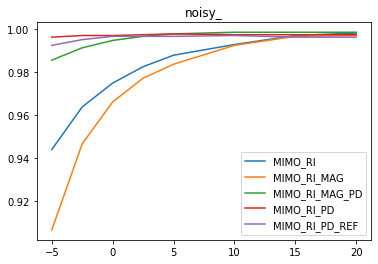

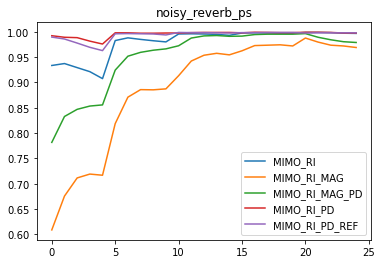

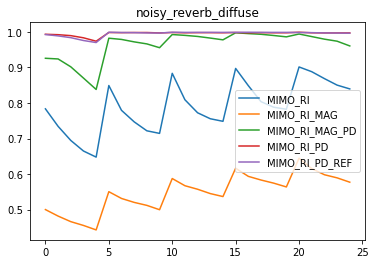

In [14]:
_plot("utt_Acc_epoch", noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_plot("utt_Acc_epoch", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_plot("utt_Acc_epoch", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")

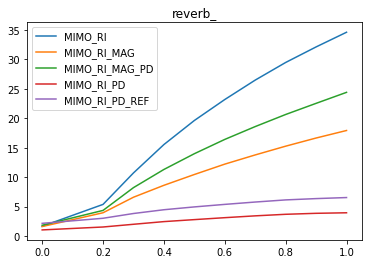

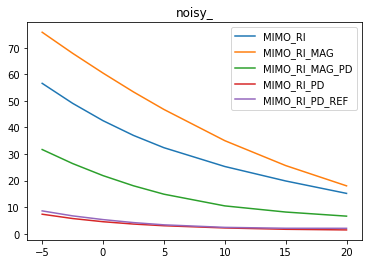

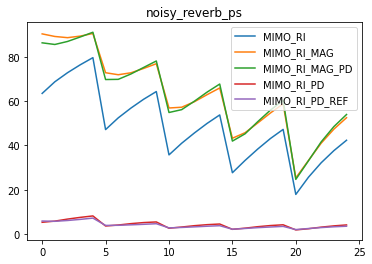

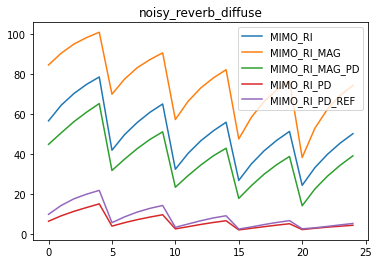

In [15]:
_plot("est_mae_overall", reverb_exp_dict, "reverb", reverb_t60_list, Loss)
_plot("mae_overall", noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_plot("mae_overall", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_plot("mae_overall", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")

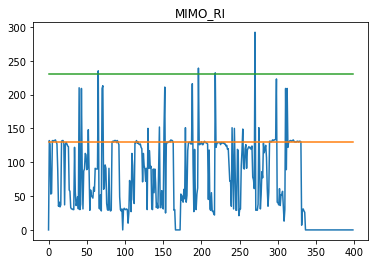

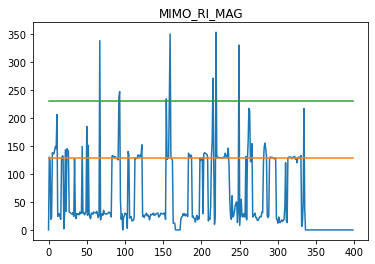

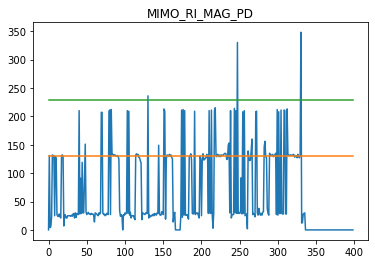

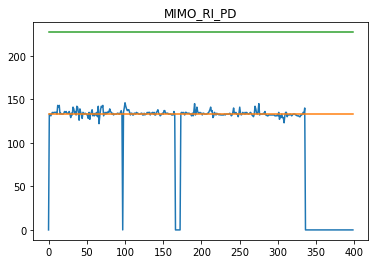

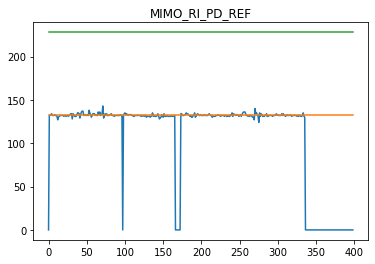

In [16]:
#debugging 
#circular array analysis
log_dir = '/fs/scratch/PAS0774/Shanmukh/ControlledExp/random_seg/dbg_signals/simu_rirs_dbg_analysis/loss_functions_comparison_circular_array/noisy_reverb/point_source/t60_0.2_snr_-5.0dB_corrected_doa_sig_norm'
loss_list = ["MIMO_RI", "MIMO_RI_MAG", "MIMO_RI_MAG_PD", "MIMO_RI_PD", "MIMO_RI_PD_REF"]
idx = 1
all_est_dict = torch.load(os.path.join(log_dir, f'doa_1.0_{idx}_tol_5.0deg_euclid_True_wgt_mech_MASK.pt'))
for loss in loss_list:
    (est_f_doa, est_f_vals, est_utt_doa, est_frm_Acc, est_utt_Acc, metrics_list, est_mae_only_correct_frms, est_mae_only_incorrect_frms, est_mae_overall_only_vad_frms) = all_est_dict[f'{loss}']
    plt.figure()
    plt.title(f'{loss}')
    plt.plot(est_f_doa)
    plt.plot(est_utt_doa*torch.ones(len(est_f_doa)))
    plt.plot(360 - est_utt_doa*torch.ones(len(est_f_doa)))



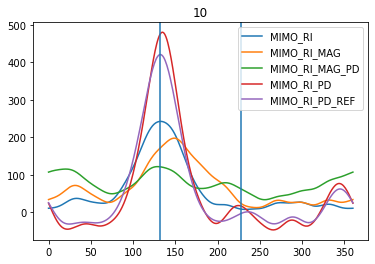

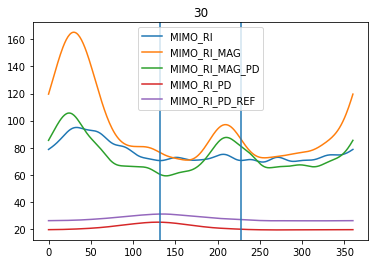

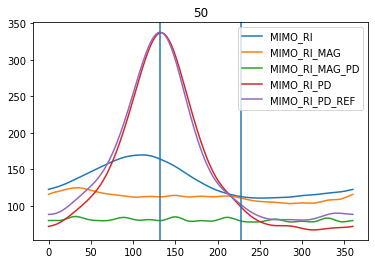

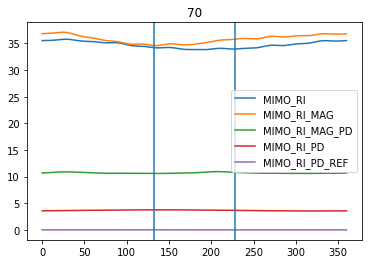

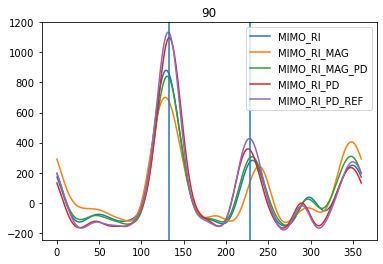

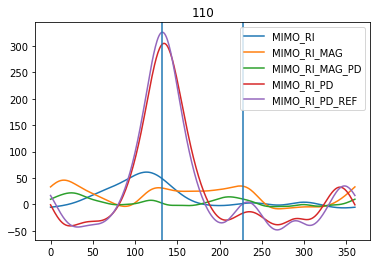

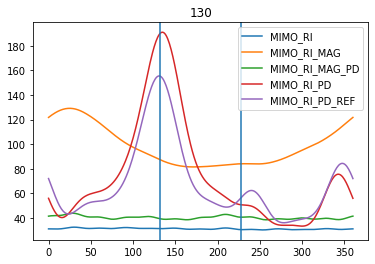

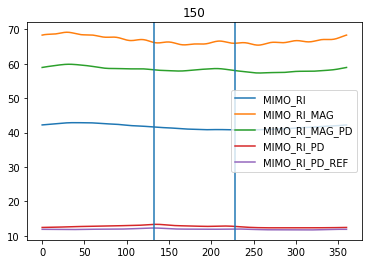

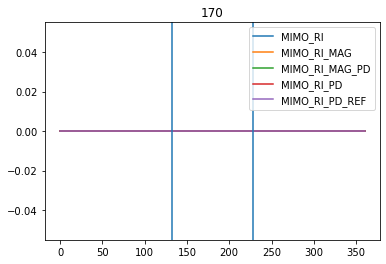

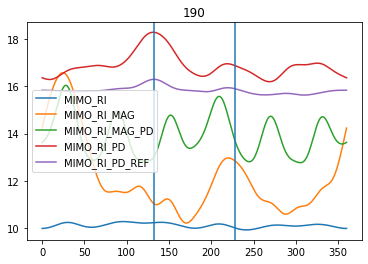

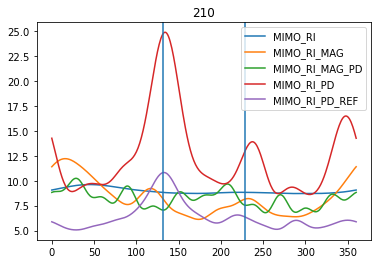

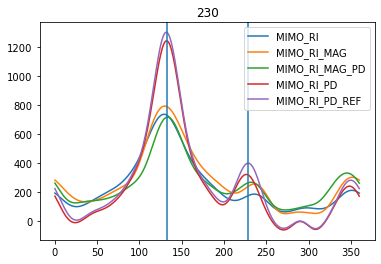

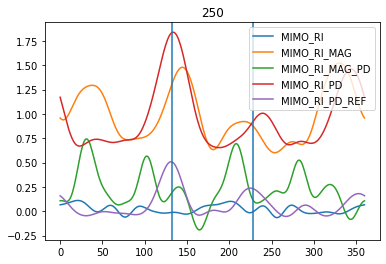

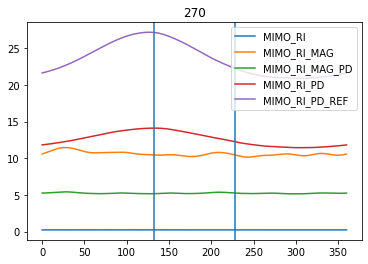

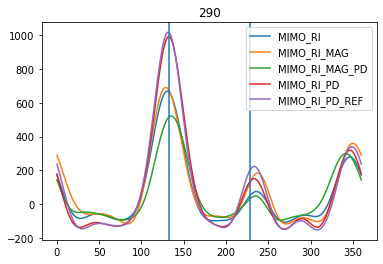

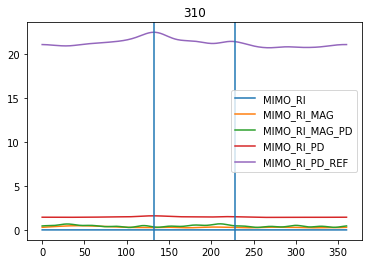

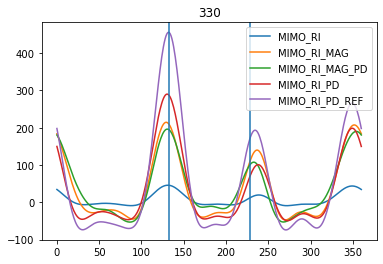

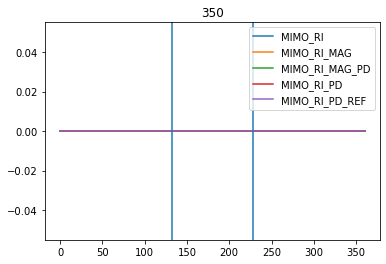

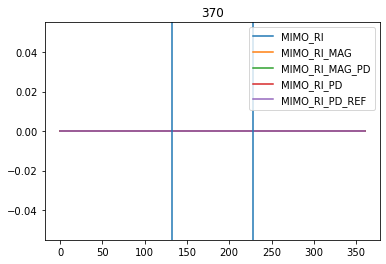

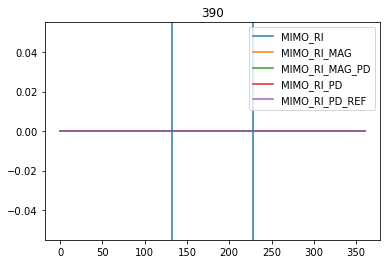

In [17]:
#circular array analysis
log_dir = '/fs/scratch/PAS0774/Shanmukh/ControlledExp/random_seg/dbg_signals/simu_rirs_dbg_analysis/loss_functions_comparison_circular_array/noisy_reverb/point_source/t60_0.2_snr_-5.0dB_corrected_doa_sig_norm'
loss_list = ["MIMO_RI", "MIMO_RI_MAG", "MIMO_RI_MAG_PD", "MIMO_RI_PD", "MIMO_RI_PD_REF"]
idx = 1
all_est_dict = torch.load(os.path.join(log_dir, f'doa_1.0_{idx}_tol_5.0deg_euclid_True_wgt_mech_MASK.pt'))
for frm in range(10, 399, 20):
    plt.figure()
    for loss in loss_list:
        (est_f_doa, est_f_vals, est_utt_doa, est_frm_Acc, est_utt_Acc, metrics_list, est_mae_only_correct_frms, est_mae_only_incorrect_frms, est_mae_overall_only_vad_frms) = all_est_dict[f'{loss}']
        #plt.figure()
        plt.title(f'{frm}')
        plt.plot(est_f_vals.flatten('F')[361*(frm-1):361*frm]) #column (theta)
    plt.axvline(x=est_utt_doa)
    plt.axvline(x=360-est_utt_doa)
    
    #plt.plot(est_utt_doa*torch.ones(361))
    #plt.plot(360 - est_utt_doa*torch.ones(361))
    plt.legend(loss_list)

In [18]:
est_utt_doa

132

In [19]:
#Linear real rirs
real_doa_measures = ["est_8mic_enh_frm_Acc"]
real_noisy_reverb_ps_log_dir = '../Logs/8cm_array_8mic/noisy_reverb/point_source_real_rirs'
real_reverb_log_dir = '../Logs/8cm_array_8mic/reverb/real_rirs'

real_search_doa_pattern_list = []
for loss in Loss:
    for measure in real_doa_measures:
        doa_info_pattern = f'{loss}_{measure}' #inside file pattern
        real_search_doa_pattern_list.append(doa_info_pattern)

real_search_doa_pattern_list.append('mix_8mic_frm_Acc_epoch')

In [20]:
real_noisy_reverb_ps_exp_dict = get_all_exp_dict(real_noisy_reverb_ps_log_dir, real_search_doa_pattern_list)
real_reverb_exp_dict = get_all_exp_dict(real_reverb_log_dir, real_search_doa_pattern_list)

In [21]:
real_noisy_reverb_ps_exp_dict

{'MIMO_RI_MAG_PD_est_8mic_enh_frm_Acc_snr_0.0_t60_0.36': 0.4912605881690979,
 'MIMO_RI_MAG_est_8mic_enh_frm_Acc_snr_0.0_t60_0.36': 0.6924976706504822,
 'MIMO_RI_PD_REF_est_8mic_enh_frm_Acc_snr_0.0_t60_0.36': 0.8823594450950623,
 'MIMO_RI_PD_est_8mic_enh_frm_Acc_snr_0.0_t60_0.36': 0.9609727263450623,
 'MIMO_RI_est_8mic_enh_frm_Acc_snr_0.0_t60_0.36': 0.8815603256225586,
 'mix_8mic_frm_Acc_epoch_snr_0.0_t60_0.36': 0.14791962504386902,
 'MIMO_RI_MAG_PD_est_8mic_enh_frm_Acc_snr_-5.0_t60_0.36': 0.31176233291625977,
 'MIMO_RI_MAG_est_8mic_enh_frm_Acc_snr_-5.0_t60_0.36': 0.5178917646408081,
 'MIMO_RI_PD_REF_est_8mic_enh_frm_Acc_snr_-5.0_t60_0.36': 0.7432851195335388,
 'MIMO_RI_PD_est_8mic_enh_frm_Acc_snr_-5.0_t60_0.36': 0.8885875940322876,
 'MIMO_RI_est_8mic_enh_frm_Acc_snr_-5.0_t60_0.36': 0.7783611416816711,
 'mix_8mic_frm_Acc_epoch_snr_-5.0_t60_0.36': 0.07069886475801468,
 'MIMO_RI_MAG_PD_est_8mic_enh_frm_Acc_snr_0.0_t60_0.61': 0.47190234065055847,
 'MIMO_RI_MAG_est_8mic_enh_frm_Acc_snr_0.0_

In [22]:
real_noisy_reverb_snr_list = [-5.0, 0.0, 5.0]
real_noisy_reverb_t60_list = [0.16, 0.36, 0.61]
real_noisy_reverb_list = list(product(real_noisy_reverb_snr_list, real_noisy_reverb_t60_list))

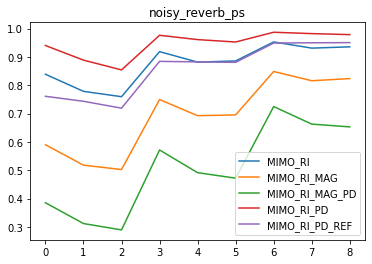

In [23]:
_plot("est_8mic_enh_frm_Acc", real_noisy_reverb_ps_exp_dict, "noisy_reverb", real_noisy_reverb_list, Loss, "ps")

In [24]:
def _print(measure, exp_dict, dataset_condition, tst_conditions, loss_list, dataset_simulation=""):
    print(tst_conditions)
    for loss in loss_list:
        val_list = []
        for tst_val in tst_conditions:
            app_str = build_app_str(dataset_condition, tst_val)
            key_str = f'{loss}_{measure}_{app_str}'

            val_list.append(exp_dict[key_str])
        print(loss, val_list)

        
        


In [25]:
_print("est_8mic_enh_frm_Acc", real_noisy_reverb_ps_exp_dict, "noisy_reverb", real_noisy_reverb_list, Loss, "ps")
_print("8mic_frm_Acc_epoch", real_noisy_reverb_ps_exp_dict, "noisy_reverb", real_noisy_reverb_list, ["mix"], "ps")

[(-5.0, 0.16), (-5.0, 0.36), (-5.0, 0.61), (0.0, 0.16), (0.0, 0.36), (0.0, 0.61), (5.0, 0.16), (5.0, 0.36), (5.0, 0.61)]
MIMO_RI [0.8387058973312378, 0.7783611416816711, 0.7594562768936157, 0.9184882640838623, 0.8815603256225586, 0.8856648206710815, 0.9528102874755859, 0.9309201836585999, 0.9354475736618042]
MIMO_RI_MAG [0.5900232791900635, 0.5178917646408081, 0.5023125410079956, 0.7493774890899658, 0.6924976706504822, 0.695080578327179, 0.8484752178192139, 0.8158233165740967, 0.8233023285865784]
MIMO_RI_MAG_PD [0.3852672874927521, 0.31176233291625977, 0.28926536440849304, 0.5714441537857056, 0.4912605881690979, 0.47190234065055847, 0.7246221303939819, 0.66275954246521, 0.6528606414794922]
MIMO_RI_PD [0.940112292766571, 0.8885875940322876, 0.8540067672729492, 0.9761995673179626, 0.9609727263450623, 0.9525277614593506, 0.9869561791419983, 0.9821253418922424, 0.9785325527191162]
MIMO_RI_PD_REF [0.7608733773231506, 0.7432851195335388, 0.7189550995826721, 0.8841584324836731, 0.882359445095

In [26]:
simu_linear_doa_measures = ["est_8mic_enh_frm_Acc"]
simu_linear_noisy_reverb_ps_log_dir = '../Logs/8cm_array_8mic/noisy_reverb/point_source'

In [27]:
simu_linear_noisy_reverb_ps_exp_dict = get_all_exp_dict(simu_linear_noisy_reverb_ps_log_dir, real_search_doa_pattern_list)

In [28]:
real_noisy_reverb_snr_list = [-5.0, 0.0, 5.0]
real_cmp_noisy_reverb_t60_list = [0.2, 0.4, 0.6]
real_cmp_noisy_reverb_list = list(product(real_noisy_reverb_snr_list, real_cmp_noisy_reverb_t60_list))

In [29]:
_print("est_8mic_enh_frm_Acc", simu_linear_noisy_reverb_ps_exp_dict, "noisy_reverb", real_cmp_noisy_reverb_list, Loss, "ps")

[(-5.0, 0.2), (-5.0, 0.4), (-5.0, 0.6), (0.0, 0.2), (0.0, 0.4), (0.0, 0.6), (5.0, 0.2), (5.0, 0.4), (5.0, 0.6)]
MIMO_RI [0.8472999930381775, 0.8124791979789734, 0.7661581635475159, 0.8982301950454712, 0.8747570514678955, 0.8461931943893433, 0.9244067668914795, 0.8999302983283997, 0.8754274249076843]
MIMO_RI_MAG [0.6866359114646912, 0.6674917340278625, 0.6353650689125061, 0.7893746495246887, 0.768425464630127, 0.7405891418457031, 0.8573107123374939, 0.8305094838142395, 0.8010860681533813]
MIMO_RI_MAG_PD [0.6434647440910339, 0.5928677320480347, 0.5405126214027405, 0.7575551271438599, 0.7047849893569946, 0.6548557877540588, 0.8343743681907654, 0.7761679887771606, 0.7254180312156677]
MIMO_RI_PD [0.9313389658927917, 0.9029072523117065, 0.8697623610496521, 0.9619726538658142, 0.9427721500396729, 0.9237058758735657, 0.9754757881164551, 0.957517683506012, 0.9409050345420837]
MIMO_RI_PD_REF [0.910888671875, 0.9077014327049255, 0.8937767148017883, 0.9412044286727905, 0.9382534623146057, 0.933806

In [30]:
_print("est_8mic_enh_frm_Acc", real_reverb_exp_dict, "reverb", real_noisy_reverb_t60_list, Loss, "")

[0.16, 0.36, 0.61]
MIMO_RI [0.9968119859695435, 0.9951526522636414, 0.996512234210968]
MIMO_RI_MAG [0.9547417759895325, 0.9481334686279297, 0.9519758820533752]
MIMO_RI_MAG_PD [0.9868976473808289, 0.9908930063247681, 0.9916130900382996]
MIMO_RI_PD [0.9919794797897339, 0.9903054237365723, 0.9913502335548401]
MIMO_RI_PD_REF [0.9977823495864868, 0.997835099697113, 0.9980208277702332]


In [31]:
_print("est_frm_Acc_epoch", reverb_exp_dict, "reverb", reverb_t60_list, Loss)
_print("frm_Acc_epoch", noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_print("frm_Acc_epoch", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_print("frm_Acc_epoch", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")

[0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
MIMO_RI [0.9920300841331482, 0.9438919425010681, 0.87921541929245, 0.8197917938232422, 0.7709656953811646, 0.7304550409317017, 0.695298969745636, 0.6651158928871155, 0.6405020952224731, 0.6201484799385071]
MIMO_RI_MAG [0.9932738542556763, 0.9708792567253113, 0.9429757595062256, 0.9169983267784119, 0.8915829062461853, 0.8681812286376953, 0.8480944633483887, 0.8282985091209412, 0.8117865920066833, 0.7991822957992554]
MIMO_RI_MAG_PD [0.9957995414733887, 0.9734867811203003, 0.9378195405006409, 0.9065285325050354, 0.8797837495803833, 0.856483519077301, 0.8351622819900513, 0.8159682154655457, 0.7994561791419983, 0.7858051657676697]
MIMO_RI_PD [0.9974302053451538, 0.9896363019943237, 0.9809398055076599, 0.9720890522003174, 0.9645642042160034, 0.9569858908653259, 0.9502507448196411, 0.9447863698005676, 0.9406832456588745, 0.9384412169456482]
MIMO_RI_PD_REF [0.994895875453949, 0.9775784611701965, 0.9561275839805603, 0.9361904859542847, 0.919827

In [32]:
_print("frm_Acc_epoch", reverb_exp_dict, "reverb", reverb_t60_list, ["mix"])
_print("7mic_frm_Acc_epoch", noisy_exp_dict, "noisy", noisy_snr_list, ["mix"])
_print("7mic_frm_Acc_epoch", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, ["mix"], "ps")
_print("7mic_frm_Acc_epoch", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, ["mix"], "diffuse")

[0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
mix [1.0, 0.9220878481864929, 0.7958518266677856, 0.6953239440917969, 0.619644045829773, 0.5616620182991028, 0.515509843826294, 0.47774025797843933, 0.44662103056907654, 0.41989806294441223]
[-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]
mix [0.07872230559587479, 0.11462929844856262, 0.16082413494586945, 0.21801137924194336, 0.2853739559650421, 0.44358745217323303, 0.6082979440689087, 0.7514491677284241]
[(-5.0, 0.2), (-5.0, 0.4), (-5.0, 0.6), (-5.0, 0.8), (-5.0, 1.0), (0.0, 0.2), (0.0, 0.4), (0.0, 0.6), (0.0, 0.8), (0.0, 1.0), (5.0, 0.2), (5.0, 0.4), (5.0, 0.6), (5.0, 0.8), (5.0, 1.0), (10.0, 0.2), (10.0, 0.4), (10.0, 0.6), (10.0, 0.8), (10.0, 1.0), (20.0, 0.2), (20.0, 0.4), (20.0, 0.6), (20.0, 0.8), (20.0, 1.0)]
mix [0.07453864067792892, 0.0901293009519577, 0.09964267909526825, 0.10386578738689423, 0.10474441200494766, 0.15421852469444275, 0.17208528518676758, 0.17775067687034607, 0.17578138411045074, 0.1709253489971161, 0.27372515201

In [38]:
_print("est_mae_only_corr", reverb_exp_dict, "reverb", reverb_t60_list, Loss)
_print("mae_only_correct", noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_print("mae_only_correct", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_print("mae_only_correct", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")

[0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
MIMO_RI [0.875545859336853, 1.1961915493011475, 1.4216327667236328, 1.568150281906128, 1.6732244491577148, 1.7529375553131104, 1.8152110576629639, 1.8660224676132202, 1.9096437692642212, 1.947810411453247]
MIMO_RI_MAG [0.8431416153907776, 1.025313138961792, 1.2012529373168945, 1.3416389226913452, 1.4519670009613037, 1.5419623851776123, 1.6165963411331177, 1.6775137186050415, 1.7293542623519897, 1.7742252349853516]
MIMO_RI_MAG_PD [0.8568629622459412, 1.1150308847427368, 1.3082764148712158, 1.4347747564315796, 1.522079586982727, 1.5937583446502686, 1.6537230014801025, 1.7036784887313843, 1.747735857963562, 1.7830698490142822]
MIMO_RI_PD [0.6664872765541077, 0.8831676244735718, 1.029430866241455, 1.139968752861023, 1.2246876955032349, 1.2948969602584839, 1.352238655090332, 1.402580976486206, 1.4457511901855469, 1.4842467308044434]
MIMO_RI_PD_REF [0.9795499444007874, 1.243438720703125, 1.408689022064209, 1.5331320762634277, 1.6252748966217

In [36]:
_print("est_mae_only_incorr", reverb_exp_dict, "reverb", reverb_t60_list, Loss)
_print("mae_only_incorrect", noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_print("mae_only_incorrect", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_print("mae_only_incorrect", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")

[0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
MIMO_RI [11.740805625915527, 69.04324340820312, 79.00373840332031, 80.94355010986328, 82.05673217773438, 83.455810546875, 84.80000305175781, 86.34943389892578, 88.0402603149414, 90.13256072998047]
MIMO_RI_MAG [11.582262992858887, 81.77228546142578, 88.22634887695312, 82.98448944091797, 79.18933868408203, 77.84262084960938, 77.18022155761719, 76.55545043945312, 76.97930908203125, 78.21845245361328]
MIMO_RI_MAG_PD [7.409394264221191, 97.66389465332031, 113.40254211425781, 112.03897857666016, 110.8001937866211, 110.83122253417969, 110.52940368652344, 110.61479949951172, 111.32502746582031, 113.24495697021484]
MIMO_RI_PD [9.295958518981934, 17.04862403869629, 24.626541137695312, 29.308862686157227, 30.795927047729492, 32.5368766784668, 34.20286178588867, 34.32317352294922, 34.306602478027344, 33.771087646484375]
MIMO_RI_PD_REF [6.615112781524658, 39.07676696777344, 42.1329345703125, 38.48746109008789, 37.51161575317383, 36.105411529541016,

In [37]:
_print("est_mae_overall", reverb_exp_dict, "reverb", reverb_t60_list, Loss)
_print("mae_overall", noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_print("mae_overall", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_print("mae_overall", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")

[0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
MIMO_RI [1.6582520008087158, 5.373763561248779, 10.714917182922363, 15.53243350982666, 19.615625381469727, 23.174358367919922, 26.472471237182617, 29.463132858276367, 32.102909088134766, 34.593971252441406]
MIMO_RI_MAG [1.6116130352020264, 3.9568653106689453, 6.591679096221924, 8.614742279052734, 10.448447227478027, 12.208964347839355, 13.771150588989258, 15.256242752075195, 16.64056968688965, 17.917648315429688]
MIMO_RI_MAG_PD [1.8346781730651855, 4.352497100830078, 8.220161437988281, 11.304669380187988, 13.978165626525879, 16.403350830078125, 18.583690643310547, 20.635009765625, 22.525959014892578, 24.392929077148438]
MIMO_RI_PD [1.0427381992340088, 1.5378296375274658, 1.9996755123138428, 2.45272159576416, 2.790243625640869, 3.120072364807129, 3.4303629398345947, 3.694713830947876, 3.8611137866973877, 3.9515931606292725]
MIMO_RI_PD_REF [2.1588494777679443, 3.019789218902588, 3.8287642002105713, 4.468430519104004, 4.947443008422852, 5

In [ ]:
#MISO 
miso_reverb_log_dir = '../Logs/8cm_array_2mic/reverb/'
miso_noisy_log_dir = '../Logs/8cm_array_2mic/noisy'
miso_noisy_reverb_ps_log_dir = '../Logs/8cm_array_2mic/noisy_reverb/point_source'
miso_noisy_reverb_diffuse_log_dir = '../Logs/8cm_array_2mic/noisy_reverb/diffuse'